# Шкарбаненко Михаил, Б05-907

# Задача 1.2

Выборка: статистика по продаже и отмене авиабилетов

1. Построить граф методом Inductive search (допускается использование любого инструмента, в том числе тех, которые не были рассказаны на семинаре, например DirectLINGAM )

2. Посчитать ACE/ATE между previous_cancellations (отменой предыдущих заказов) и known_client (клиент известен системе)

3. Посчитать ACE/ATE между previous_cancellations (отменой предыдущих заказов) и known_client (клиент известен системе) напрямую, без использования графа

4. Сравнить и проинтерпретировать результат

5. Предложить свой граф зависимостей, исходя из здравого смысла

6. Посчитать ACE/ATE между всеми наборами признаков без использования графа и с использованием своего графа. Объяснить разницу.

Допускается использование подвыборок для построения графа.

## Подготовительная часть

### Библиотеки

In [202]:
try:
  import causality, causalgraphicalmodels, lingam
except ModuleNotFoundError:
  ! pip install causality
  ! pip install causalgraphicalmodels
  ! pip install lingam

In [203]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

import pandas as pd
import seaborn as sns

from causality.estimation.adjustments import AdjustForDirectCauses
from causality.estimation.nonparametric import CausalEffect
from causality.inference.search import IC
from causality.inference.independence_tests import MutualInformationTest
from causalgraphicalmodels import CausalGraphicalModel

import lingam
from lingam.utils import make_dot
from sklearn.preprocessing import OrdinalEncoder

### Данные

In [204]:
data = pd.read_csv('https://raw.githubusercontent.com/Intelligent-Systems-Phystech/psad/master/labs/lab2/data/flight_tickets.csv')
data.head()

,lead_time,meal,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,days_in_waiting_list,customer_type,total_of_special_requests,clients,resort_travel,known_client,required_taxi,short_trip,canceled
0,342,True,0,0,3,No Deposit,0,Transient,0,2.0,True,0,0,True,False
1,737,True,0,0,4,No Deposit,0,Transient,0,2.0,True,0,0,True,False
2,7,True,0,0,0,No Deposit,0,Transient,0,1.0,True,0,0,False,False
3,13,True,0,0,0,No Deposit,0,Transient,0,1.0,True,0,0,False,False
4,14,True,0,0,0,No Deposit,0,Transient,1,2.0,True,0,0,False,False


In [205]:
# Data preprocessing
cat_cols = []
for col in data:
  if data[col].dtype in ('O', 'bool'):
    cat_cols.append(col)

encoder = OrdinalEncoder()
data[cat_cols] = encoder.fit_transform(data[cat_cols]).astype('int64')
data.clients = data.clients.astype('int64')
data.head()

,lead_time,meal,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,days_in_waiting_list,customer_type,total_of_special_requests,clients,resort_travel,known_client,required_taxi,short_trip,canceled
0,342,1,0,0,3,0,0,2,0,2,1,0,0,1,0
1,737,1,0,0,4,0,0,2,0,2,1,0,0,1,0
2,7,1,0,0,0,0,0,2,0,1,1,0,0,0,0
3,13,1,0,0,0,0,0,2,0,1,1,0,0,0,0
4,14,1,0,0,0,0,0,2,1,2,1,0,0,0,0


## 1. Граф методом Inductive search

Полный граф взаимосвязей между признаками, построенный на всей имеющейся выборке.

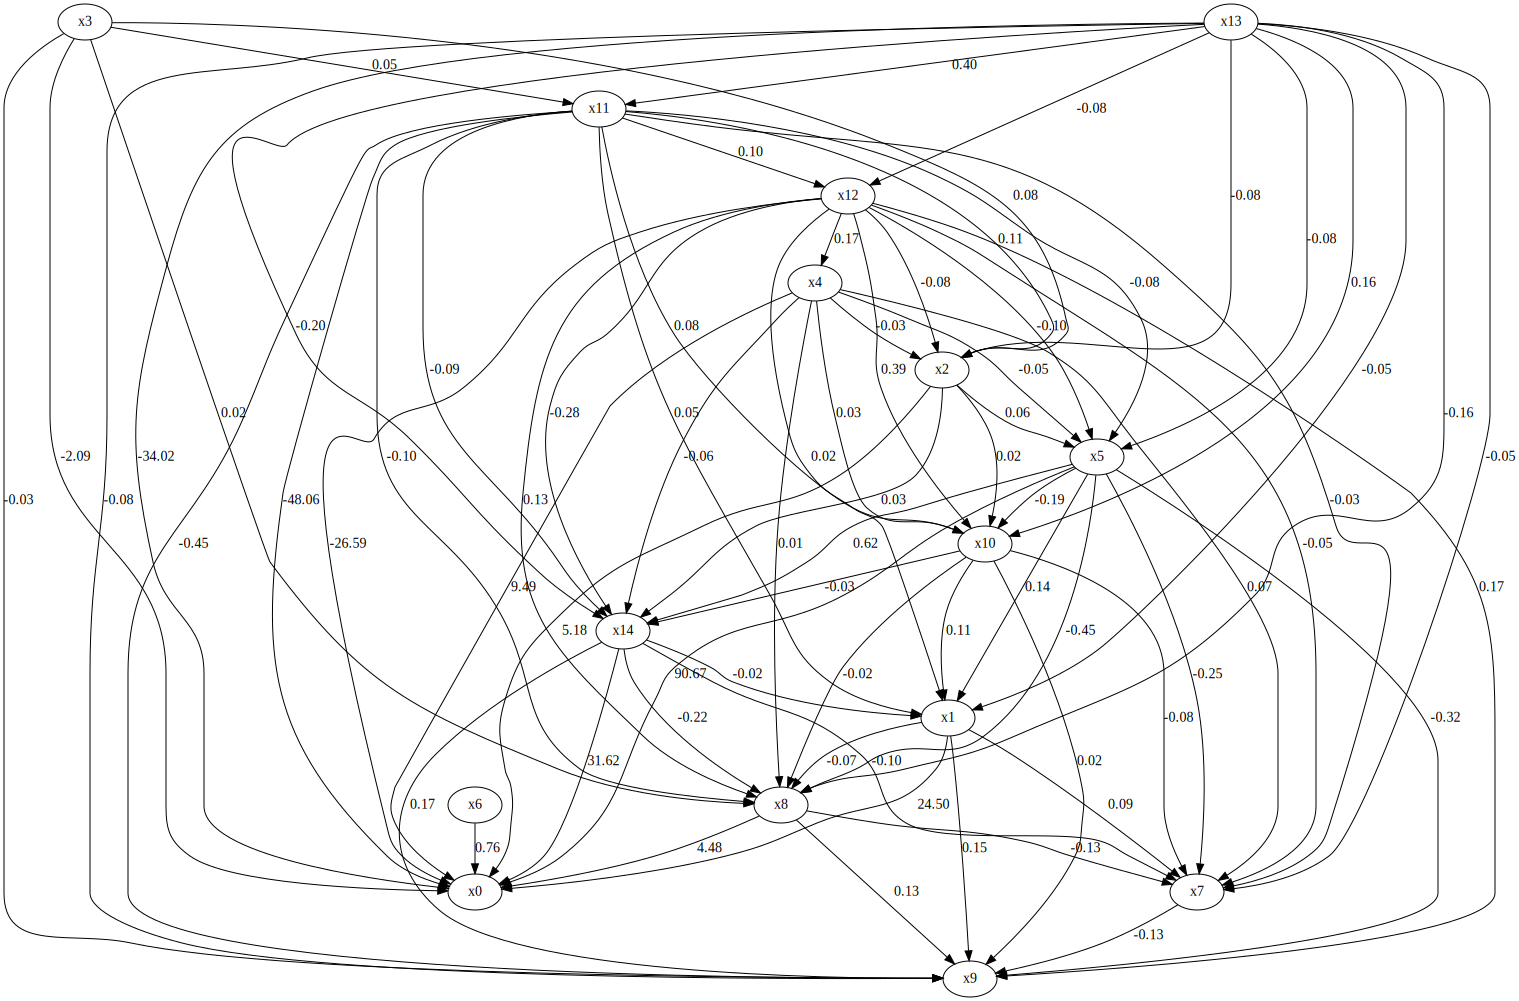

In [206]:
model = lingam.DirectLiNGAM()
model.fit(data)
make_dot(model.adjacency_matrix_)

Граф слишком громоздкий, а большинство связей довольно слабые и, скорее всего, их на самом деле не существует. Упростим граф, оставив только наиболее значимые связи.

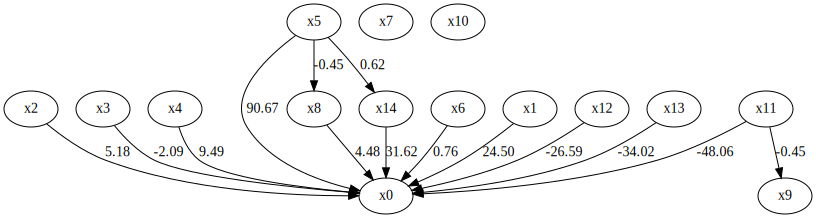

In [207]:
adj_matrix = model.adjacency_matrix_
adj_matrix = np.array([[val if abs(val) > 0.4 else 0 for val in row] for row in adj_matrix])
make_dot(adj_matrix)

Выглядит граф довольно странно. Алгоритм считает, что центральное звено - это lead time и оно зависит от большинства других признаков и причем взаимосвязи между парами признаков, куда lead time не входит, напорядок слабее. Скорее всего многие из полученных связей являются все таки статистическими, а не причинно-следственными. Например, вряд ли время подачи самолета зависит от того, подают ли еду во время полета. Попробуем исключить этот признак и построить новый граф.

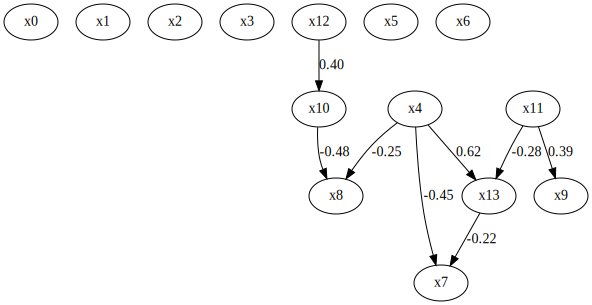

In [208]:
model = lingam.DirectLiNGAM()
data = data.drop('lead_time', axis=1)
model.fit(data)
adj_matrix = model.adjacency_matrix_
adj_matrix = np.array([[val if abs(val) > 0.2 else 0 for val in row] for row in adj_matrix])
make_dot(adj_matrix)

Этот граф выглядит намного более осмысленно. Например, связь x12 -> x10 - если клиенту требуется такси, возможно, что с большей вероятностью это поездка на отдых.

In [209]:
for i, val in enumerate(data.columns.values): print(i, val)

0 meal
1 previous_cancellations
2 previous_bookings_not_canceled
3 booking_changes
4 deposit_type
5 days_in_waiting_list
6 customer_type
7 total_of_special_requests
8 clients
9 resort_travel
10 known_client
11 required_taxi
12 short_trip
13 canceled


## 2. ACE по графу

ACE равен 0, так как нет какого-либо внешнего фактора влияюшего на previous_cancellations кроме known_client.

## 3. ACE напрямую

Оценим эффект на небольшом сэмпле, так время работы алгоритма на всей выборке слишком велико.

In [210]:
variable_types = {col:"u" for col in data.columns}
effect = CausalEffect(data.sample(1000), ['known_client'], ['previous_cancellations'], 
                      variable_types=variable_types,
                      admissable_set=[])
known_client = pd.DataFrame({'known_client': [1], 'previous_cancellations': [1]})
previous_cancellations = pd.DataFrame({'known_client': [0], 'previous_cancellations': [1]})

In [211]:
effect.pdf(known_client) - effect.pdf(previous_cancellations)

0.08631818375917154

## 4. Интерпретация результатов

Значения ACE не совпадли при расчете различными методам. Скорее всего это связано со случайностью выборки во втором методе и с тем, что ребра с незначительным весом были удалены из матрицы смежности, но, скорее всего, они оказывают весомый интервенционный эффект на конкретные признаки: known_client, previous_cancellations. 

## 5. Собственный граф зависимостей

Небольшой подграф на части признаков. Полный или близкий к полному граф  построить невозможно, так как можно предположить слишком много потенциальных взаимосвязей между признаками.

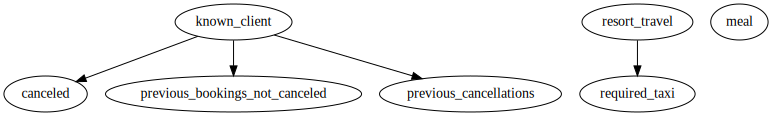

In [212]:
nodes=['known_client', 'meal', 'canceled', 'previous_cancellations', 'previous_bookings_not_canceled', 'resort_travel', 'required_taxi']
edges=[('known_client','canceled'),
       ('known_client','previous_cancellations'),
       ('known_client','previous_bookings_not_canceled'),
       ('resort_travel', 'required_taxi')]
G = CausalGraphicalModel(nodes=nodes, edges=edges)
G.draw()